# SIMULATION OF SELECTION BIAS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import pickle
from scipy.special import expit
import optuna
import json

In [3]:
from model_class import CatBoostXT_BAG

In [4]:
from model_class_lgbm import LightGBMXT_BAG

In [5]:
from model_utils import *

In [6]:
from other_utils import compare_distributions

In [7]:
data_dir = r'E:\Project\Dissertation'

In [8]:
list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [9]:
df = pd.read_parquet(rf'{data_dir}\data\processed\master_data_flagged_trainval.parquet')

In [10]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR','flag_train_val']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
# list ethical features
list_ethical_features = [col for col in df.columns if 'GENDER' in col]
# list categorical features
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features = list(set(list_cat_features)-set(list_ethical_features)-set(['flag_train_val']))

In [11]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [12]:
df_bureau  = pd.read_csv(rf'{data_dir}\home-credit-default-risk\bureau.csv')

In [13]:
df['flag_has_bureau'] = np.where(df['SK_ID_CURR'].isin(df_bureau['SK_ID_CURR']),1,0)

## Simulate credit policies

Simulate selection bias and missing types by simulating credit policies:

Missing Not At a Random (MNAR):  ommitted from both oracle model and all subsequent models of the research --> drive approval process but not existed in training
- Exteral scoring EXT_MEAN: <20 --> reject, >80 --> good customers that cannot accquire due to competition -- stochastic 
- Customer with no bureau ever before: can be approximate using missing value of bureau features -- deterministic

Missing At a Random (MAR): drive approval process and used for training
- AGE_YEARS: >= 30, <= 60 -- stochastic 
- CREDIT_TO_INCOME: >4 -- stochastic 
- No defaut status > 1 (>60DPD in the last 12 months) -- deterministic




### Check distribution

In [17]:
df[['FLAG_OWN_CAR']].value_counts()

FLAG_OWN_CAR
N               202924
Y               104587
Name: count, dtype: int64

In [18]:
df[['EXT_MEAN']].describe()

,EXT_MEAN
count,307339.000000
mean,0.509251
std,0.149802
min,0.000006
25%,0.413648
50%,0.524502
75%,0.622819
max,0.878903


In [19]:
df[['AGE_YEARS']].describe()

,AGE_YEARS
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [20]:
df[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,307511.000000
mean,3.957570
std,2.689728
min,0.004808
25%,2.018667
50%,3.265067
75%,5.159880
max,84.736842


In [21]:
df[['bb_w12_status_max__max']].value_counts()

bb_w12_status_max__max
0.0                       57661
1.0                       12914
5.0                         962
2.0                         897
3.0                         201
4.0                         137
Name: count, dtype: int64

In [22]:
df[['flag_has_bureau']].value_counts()

flag_has_bureau
1                  263491
0                   44020
Name: count, dtype: int64

### Create policies

#### Deterministic policies

In [23]:
def approval_policies_deterministic():
    approval_mask = (
        (df['bb_w12_status_max__max'].fillna(0) <= 1) &
        (df['flag_has_bureau'].fillna(0) == 1)
    )
    return approval_mask

In [24]:
mask_deterministic_approval = approval_policies_deterministic()

In [25]:
mask_deterministic_approval

0         False
1          True
2          True
3          True
4          True
          ...  
307506     True
307507     True
307508     True
307509     True
307510     True
Length: 307511, dtype: bool

In [26]:
mask_deterministic_approval.value_counts()

True     261294
False     46217
Name: count, dtype: int64

#### Probabilistic Policy Override

In [27]:
def probabilistic_override_model(deterministic_mask, threshold=0.05, random_state=1):
    soft_approval = (
        (df['EXT_MEAN'].fillna(0).between(0.5,0.8)) &
        (df['AGE_YEARS'].fillna(40).between(30,50)) &
        (df['CREDIT_TO_INCOME'].fillna(1).between(0,3))
    )
    
    np.random.seed(random_state)
    # take 5% of the rejected applications, return the index
    override_mask = (np.random.uniform(0,1,len(soft_approval)) < threshold)


    return deterministic_mask & (soft_approval | override_mask)

In [28]:
mask_final_approval = probabilistic_override_model(mask_deterministic_approval,threshold=0.05)

In [29]:
df_simulation = df.loc[mask_final_approval].copy()

In [30]:
df['flag_accepted'] = np.where(mask_final_approval,1,0)

In [31]:
df.to_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval_and_reject.parquet',index=False)

In [32]:
df_simulation.to_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval.parquet',index=False)

In [33]:
df_simulation = pd.read_parquet(rf'{data_dir}\data\processed\master_data_simulated_approval.parquet',index=False)

In [34]:
df_simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Columns: 590 entries, SK_ID_CURR to flag_has_bureau
dtypes: float64(520), int32(1), int64(47), object(22)
memory usage: 205.7+ MB


### Visualise the impact

##### Credit filter features

In [35]:
df_simulation[['EXT_MEAN']].describe()

,EXT_MEAN
count,45728.000000
mean,0.579405
std,0.105199
min,0.000492
25%,0.528532
50%,0.584866
75%,0.648866
max,0.840821


In [36]:
df_simulation[['AGE_YEARS']].describe()

,AGE_YEARS
count,45730.000000
mean,41.301168
std,8.055693
min,21.134247
25%,35.392466
50%,40.723288
75%,46.155479
max,68.986301


In [37]:
df_simulation[['CREDIT_TO_INCOME']].describe()

,CREDIT_TO_INCOME
count,45730.000000
mean,2.499781
std,1.785552
min,0.066667
25%,1.500000
50%,2.142857
75%,2.812500
max,27.970000


invalid value encountered in multiply


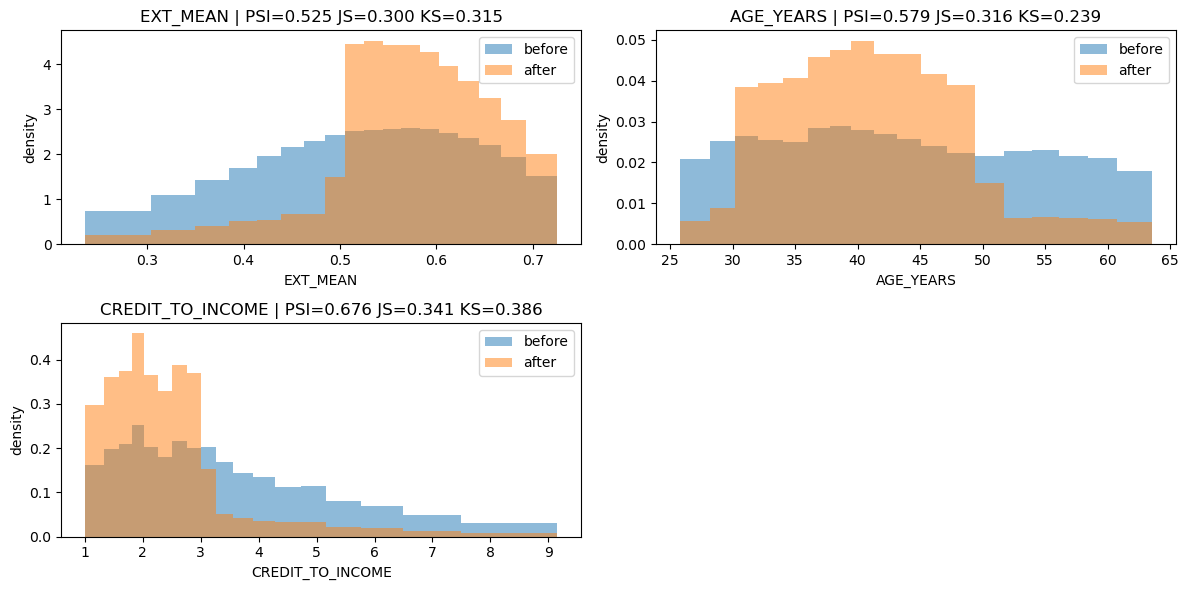

,feature,type,psi,js,ks,chi2_p,n_before,n_after
0,EXT_MEAN,numeric,0.525155,0.300222,0.314811,NaN,307339,45728
1,AGE_YEARS,numeric,0.578965,0.315695,0.239394,NaN,307511,45730
2,CREDIT_TO_INCOME,numeric,0.675538,0.341027,0.386345,NaN,307511,45730


In [38]:
compare_distributions(before=df, after=df_simulation, features=['EXT_MEAN','AGE_YEARS','CREDIT_TO_INCOME'],plot=True)

#### Most important features in oracle model

In [39]:
# load pickle
with open(rf'{data_dir}\models\oracle_model_catboostxt_bag.pkl', 'rb') as f:
    oracle_model = pickle.load(f)

In [40]:
df_oracle_shap_imp = oracle_model.feature_importances_shap_
df_oracle_shap_imp.head(10)['feature'].to_list()

['ANNUITY_TO_CREDIT',
 'GOODS_TO_CREDIT',
 'NAME_EDUCATION_TYPE',
 'OCCUPATION_TYPE',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'w720_utilization_portfolio',
 'DAYS_LAST_PHONE_CHANGE']

#### SHAP Summary

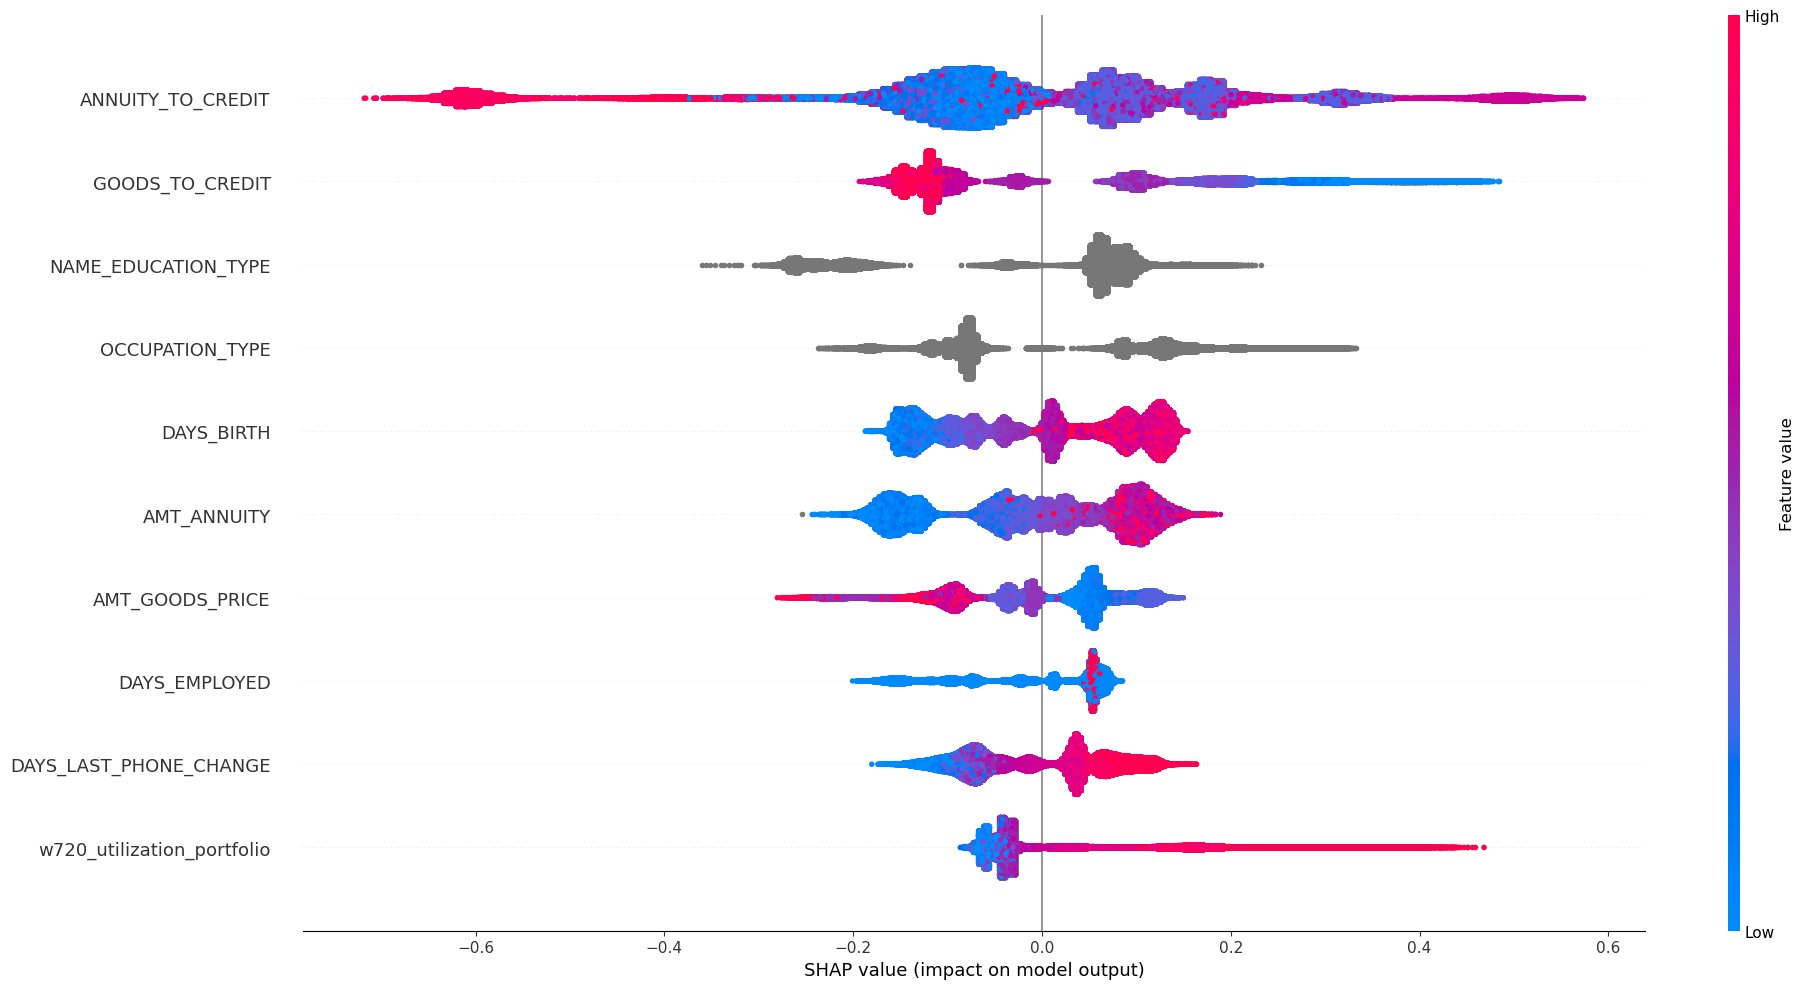

In [ ]:
oracle_model.plot_shap_summary_plot(df[oracle_model.used_features],max_display=10, plot_size=(20,10))

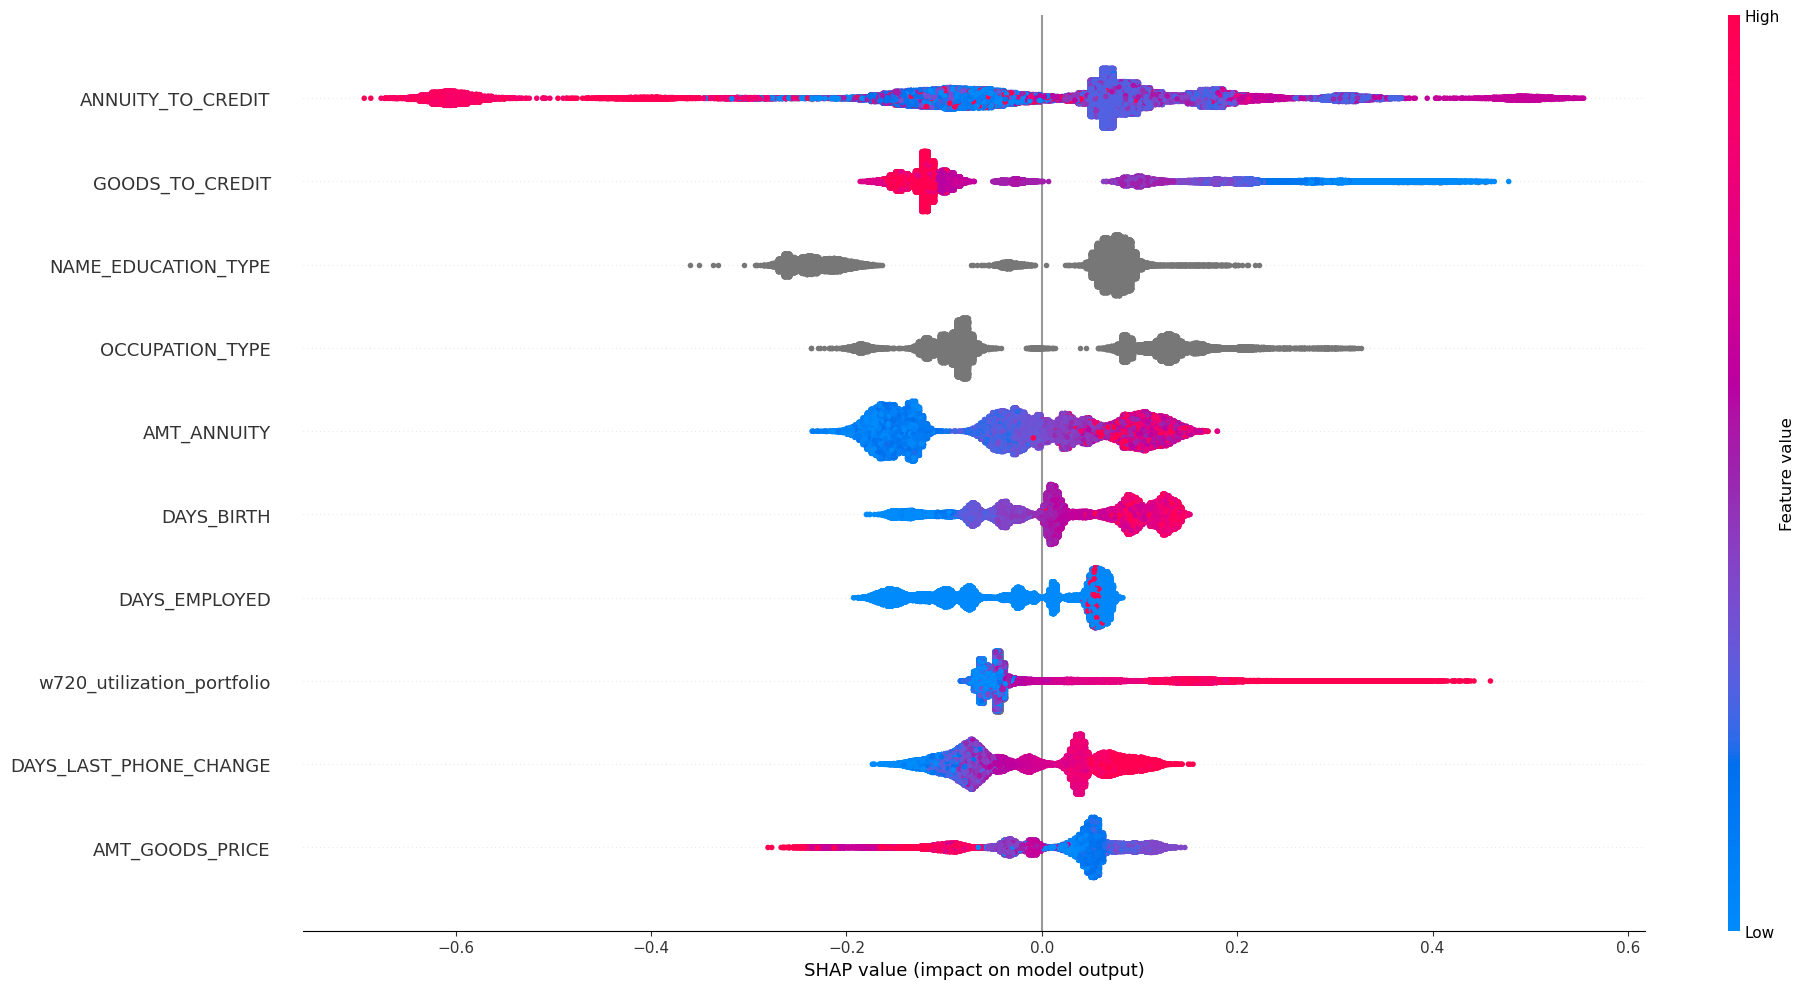

In [486]:
oracle_model.plot_shap_summary_plot(df_simulation[oracle_model.used_features],max_display=10, plot_size=(20,10))

#### Distribution

invalid value encountered in multiply
invalid value encountered in multiply


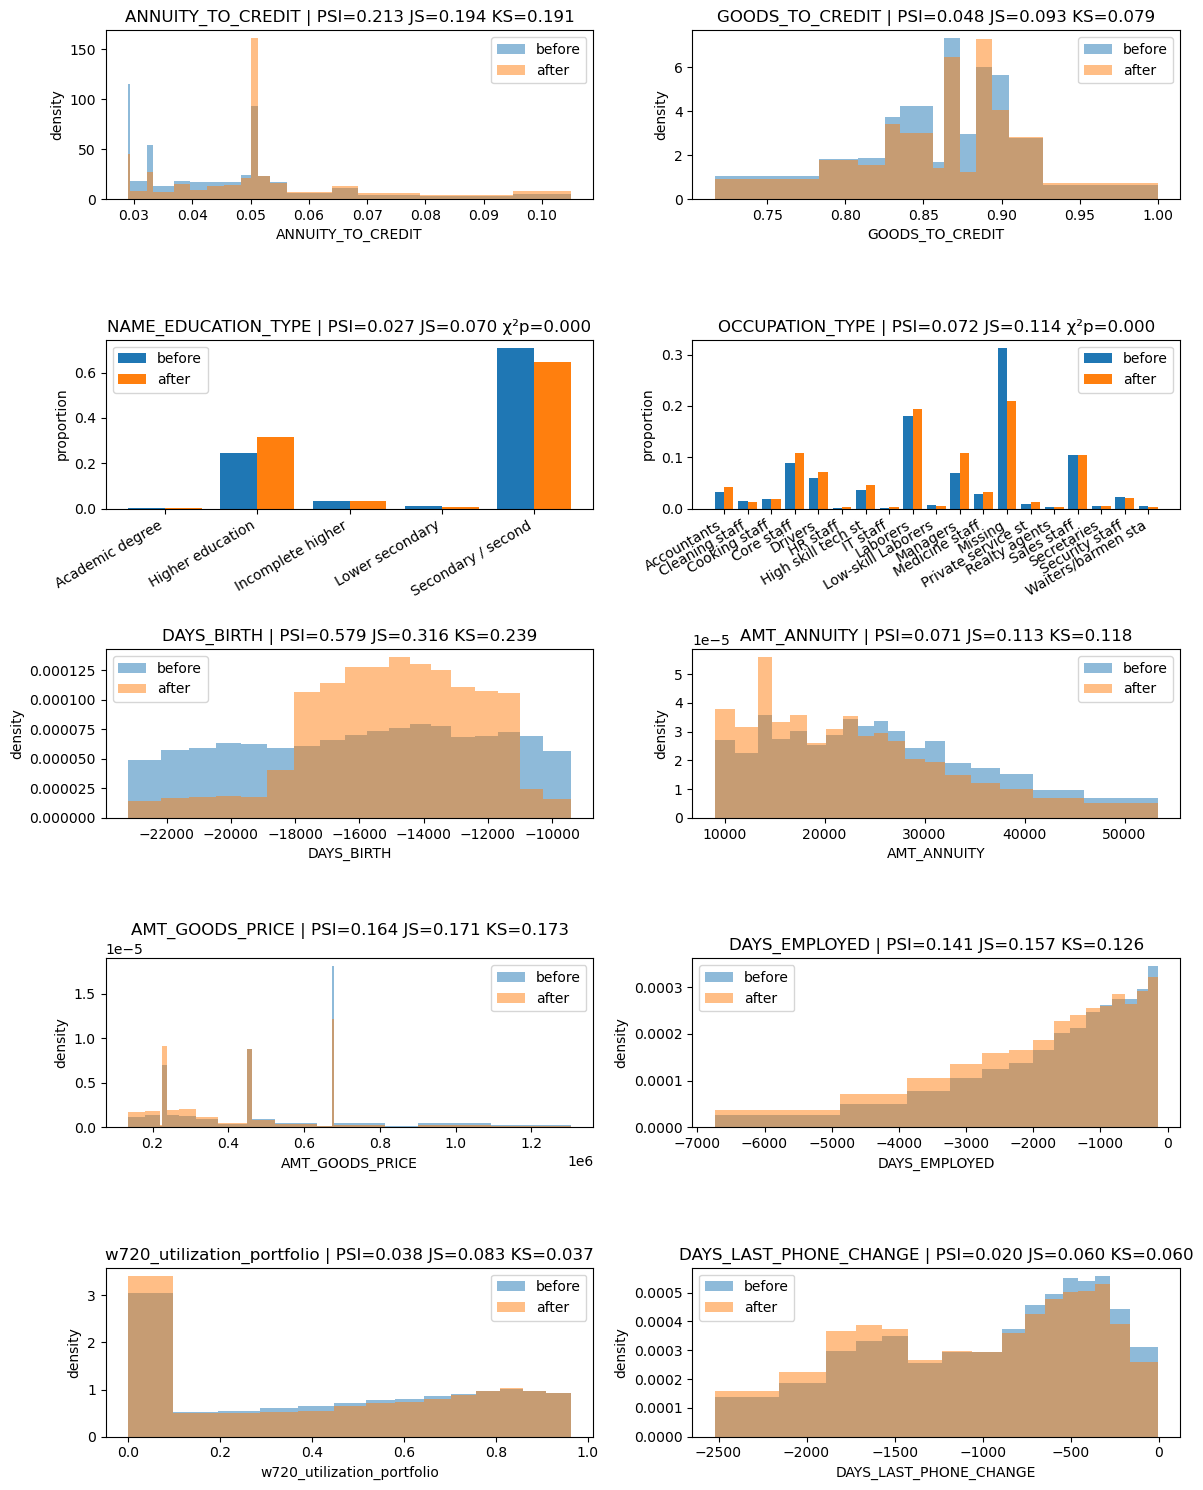

,feature,type,psi,js,ks,chi2_p,n_before,n_after
0,ANNUITY_TO_CREDIT,numeric,0.212576,0.194082,0.191285,NaN,307499,45728
1,GOODS_TO_CREDIT,numeric,0.048329,0.092846,0.079348,NaN,307233,45657
2,NAME_EDUCATION_TYPE,categorical,0.026871,0.069508,NaN,3.612212e-281,307511,45730
3,OCCUPATION_TYPE,categorical,0.072474,0.113979,NaN,0.000000e+00,307511,45730
4,DAYS_BIRTH,numeric,0.578782,0.315652,0.239394,NaN,307511,45730
5,AMT_ANNUITY,numeric,0.070716,0.112644,0.117875,NaN,307499,45728
6,AMT_GOODS_PRICE,numeric,0.163735,0.170620,0.173209,NaN,307233,45657
7,DAYS_EMPLOYED,numeric,0.140936,0.157304,0.125867,NaN,307511,45730
8,w720_utilization_portfolio,numeric,0.038139,0.082817,0.037147,NaN,207240,34535
9,DAYS_LAST_PHONE_CHANGE,numeric,0.020000,0.059948,0.060170,NaN,307510,45730


In [488]:
compare_distributions(
    before=df, 
    after=df_simulation, 
    features=df_oracle_shap_imp.head(10)['feature'].to_list(),
    plot=True)

In [483]:
compare_distributions(
    before=df, 
    after=df_simulation, 
    features=df_oracle_shap_imp.head(20)['feature'].to_list(),
    plot=False)

,feature,type,psi,js,ks,chi2_p,n_before,n_after
0,ANNUITY_TO_CREDIT,numeric,0.212576,0.194082,0.191285,NaN,307499,45728
1,GOODS_TO_CREDIT,numeric,0.048329,0.092846,0.079348,NaN,307233,45657
2,NAME_EDUCATION_TYPE,categorical,0.026871,0.069508,NaN,3.612212e-281,307511,45730
3,OCCUPATION_TYPE,categorical,0.072474,0.113979,NaN,0.000000e+00,307511,45730
4,DAYS_BIRTH,numeric,0.578782,0.315652,0.239394,NaN,307511,45730
5,AMT_ANNUITY,numeric,0.070716,0.112644,0.117875,NaN,307499,45728
6,AMT_GOODS_PRICE,numeric,0.163735,0.170620,0.173209,NaN,307233,45657
7,DAYS_EMPLOYED,numeric,0.140936,0.157304,0.125867,NaN,307511,45730
8,w720_utilization_portfolio,numeric,0.038139,0.082817,0.037147,NaN,207240,34535
9,DAYS_LAST_PHONE_CHANGE,numeric,0.020000,0.059948,0.060170,NaN,307510,45730


## BASE MODEL ON BIASED DATA

In [41]:
df_simulation[['flag_train_val']].value_counts()

flag_train_val
train             34294
valid             11436
Name: count, dtype: int64

In [42]:
list_features = oracle_model.used_features
list_cat_features = oracle_model.cat_features

In [43]:
X_sim_train = df_simulation.loc[df_simulation['flag_train_val']=='train',list_features]
X_sim_val = df_simulation.loc[df_simulation['flag_train_val']=='valid',list_features]

y_sim_train = df_simulation.loc[df_simulation['flag_train_val']=='train',label_col]
y_sim_val = df_simulation.loc[df_simulation['flag_train_val']=='valid',label_col]

In [44]:
y_sim_train.value_counts()

TARGET
0    32697
1     1597
Name: count, dtype: int64

In [45]:
y_sim_val.value_counts()

TARGET
0    10890
1      546
Name: count, dtype: int64

#### Tunning

In [652]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-09-20 22:21:08,584] A new study created in memory with name: no-name-9c8423a3-645d-415b-92ae-00fc15feec7f


In [649]:
def objective(trial):
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 6),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'border_count': 128,
        'auto_class_weights': 'SqrtBalanced',
        'early_stopping_rounds': None,
        'od_type': 'IncToDec',
        'od_wait': 200,
        'od_pval': 0.01,
        'boosting_type': 'Ordered',
        'bootstrap_type': 'Bernoulli',
        'loss_function': 'Logloss', 
        'eval_metric': 'Logloss',
        'task_type':'GPU',
        'devices':'0',
    }
    
    model = CatBoostXT_BAG(
        num_bag_folds=1,
        num_bag_repeats=1,
        random_state=1,
        cat_features=list_cat_features
        )
    model.params = param
    model.fit(X_sim_train, y_sim_train,eval_set=(X_sim_val, y_sim_val))
    
    train_pred = model.predict_proba(X_sim_train)[:,1]
    val_pred = model.predict_proba(X_sim_val)[:,1]
    train_metric = f_roc_auc(y_sim_train, train_pred)
    val_metric = f_roc_auc(y_sim_val, val_pred)
    
    return val_metric - 1*abs(val_metric - train_metric)

In [653]:
study.enqueue_trial({'learning_rate': 0.03472127372580367, 'depth': 4, 'l2_leaf_reg': 93})

In [654]:
study.optimize(objective, n_trials=50)

[I 2025-09-20 22:22:24,153] Trial 0 finished with value: 0.6221545607599527 and parameters: {'learning_rate': 0.03472127372580367, 'depth': 4, 'l2_leaf_reg': 93}. Best is trial 0 with value: 0.6221545607599527.
[I 2025-09-20 22:23:26,108] Trial 1 finished with value: 0.6163838720256413 and parameters: {'learning_rate': 0.05034750760454589, 'depth': 5, 'l2_leaf_reg': 10}. Best is trial 0 with value: 0.6221545607599527.
[I 2025-09-20 22:24:48,690] Trial 2 finished with value: 0.5979357441888836 and parameters: {'learning_rate': 0.02995102673924723, 'depth': 6, 'l2_leaf_reg': 23}. Best is trial 0 with value: 0.6221545607599527.
[I 2025-09-20 22:26:40,218] Trial 3 finished with value: 0.592158787636317 and parameters: {'learning_rate': 0.013498826895087532, 'depth': 6, 'l2_leaf_reg': 60}. Best is trial 0 with value: 0.6221545607599527.
[I 2025-09-20 22:27:57,831] Trial 4 finished with value: 0.6168789323431945 and parameters: {'learning_rate': 0.021585056759432827, 'depth': 5, 'l2_leaf_reg

In [750]:
study.best_params

{'learning_rate': 0.010353843378600744, 'depth': 4, 'l2_leaf_reg': 89}

In [ ]:
# Save study to pickle
with open(rf'{data_dir}\models\base_model_optuna_study_cb.pkl', 'wb') as f:
    pickle.dump(study, f)

# Load and continue optimization
with open(rf'{data_dir}\models\base_model_optuna_study_cb.pkl', 'rb') as f:
    loaded_study = pickle.load(f)

#### Fit optimized model

In [46]:
base_model = CatBoostXT_BAG(
    num_bag_folds=1,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)

In [51]:
base_model.params = {
    'iterations': 3000,
    'learning_rate': 0.010353843378600744,
    'depth': 4,
    'l2_leaf_reg': 89,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 200,
    'od_pval': 0.01,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [52]:
base_model.fit(X_sim_train, y_sim_train, eval_set=(X_sim_val, y_sim_val))

In [53]:
base_model.evaluate(X_sim_train,y_sim_train)

{'ROC_AUC': 0.7957728950486325, 'PR_AUC': 0.2271600619576925}

In [54]:
base_model.evaluate(X_sim_val,y_sim_val)

{'ROC_AUC': 0.715731574822484, 'PR_AUC': 0.12719887385828152}

In [55]:
base_model.get_average_shap_feature_importance(X_sim_train)

,feature,importance
0,NAME_EDUCATION_TYPE,0.209086
1,ANNUITY_TO_CREDIT,0.132088
2,OCCUPATION_TYPE,0.099352
3,ANNUITY_TO_INCOME,0.096907
4,GOODS_TO_CREDIT,0.087510
...,...,...
571,bb_w12_share_status_gt4__sum,0.000000
572,CNT_CHILDREN,0.000000
573,w360_current_overdue_amt,0.000000
574,FLAG_DOCUMENT_11,0.000000


In [56]:
base_model.get_feature_importance(X_sim_train)

,feature,importance
0,ANNUITY_TO_CREDIT,9.517081
1,NAME_EDUCATION_TYPE,8.231639
2,ANNUITY_TO_INCOME,3.408267
3,AMT_ANNUITY,3.019262
4,GOODS_TO_CREDIT,2.988465
...,...,...
571,bb_w12_share_status_gt4__sum,0.000000
572,CNT_CHILDREN,0.000000
573,w360_current_overdue_amt,0.000000
574,FLAG_DOCUMENT_11,0.000000


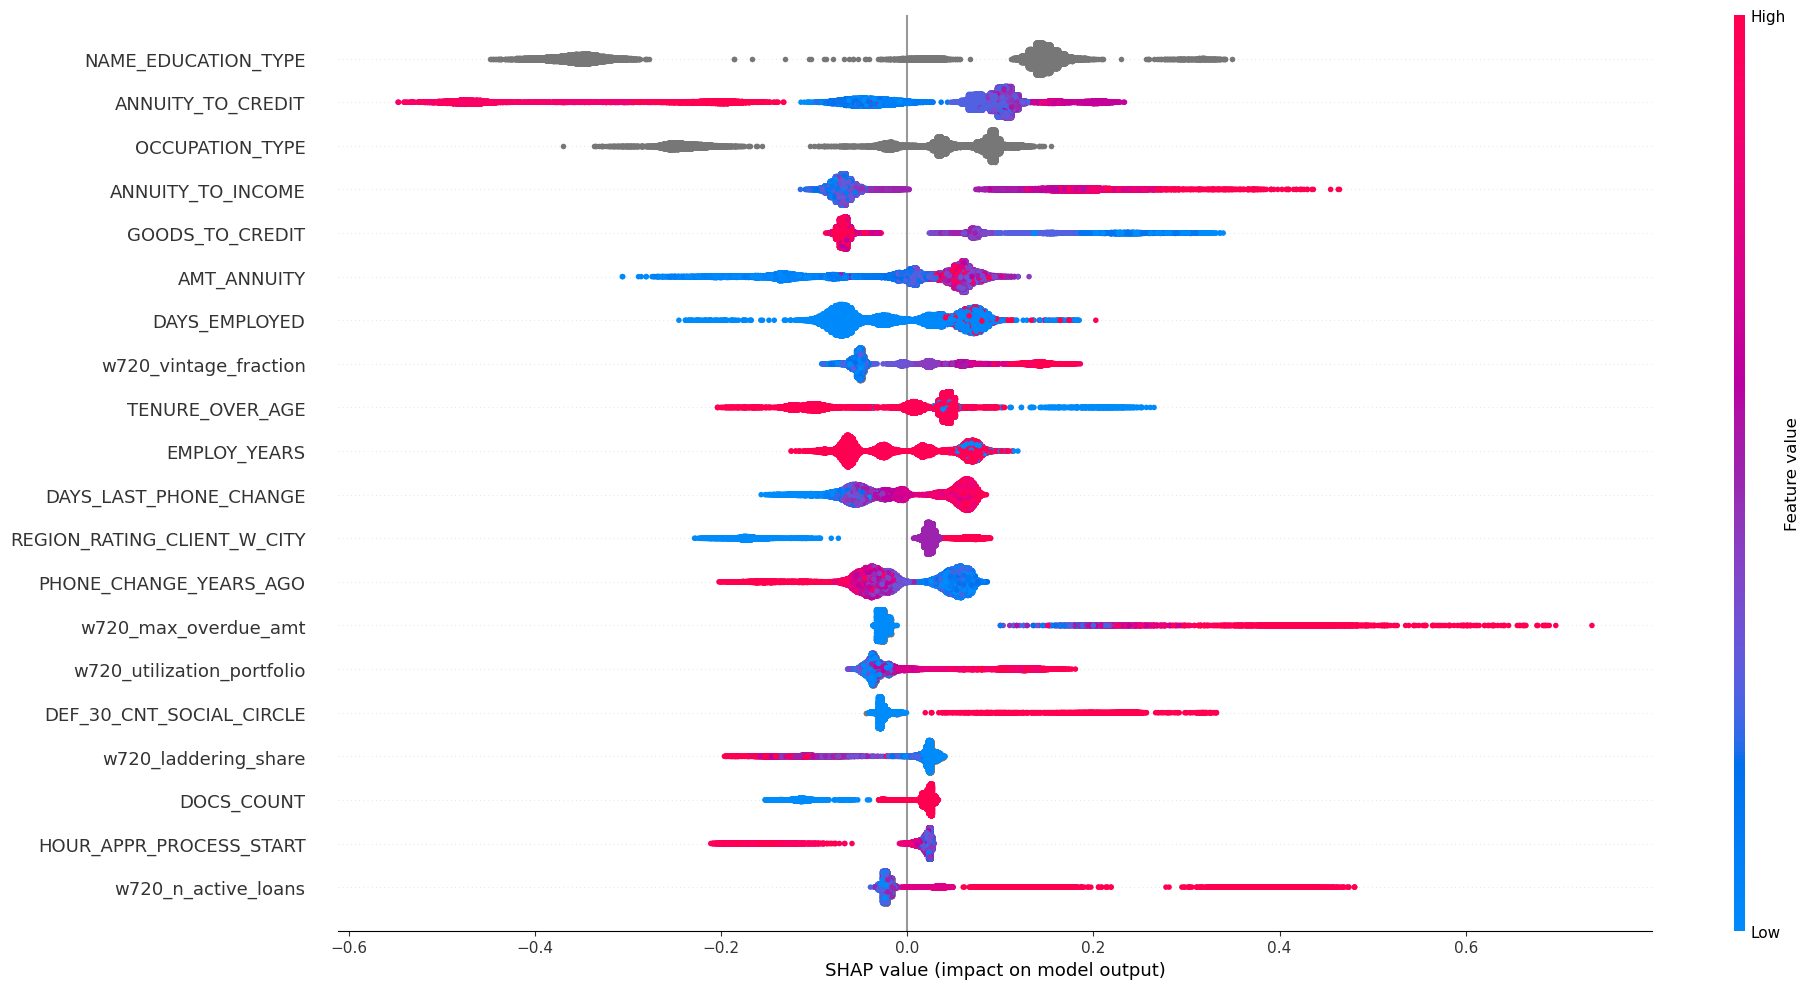

In [57]:
base_model.plot_shap_summary_plot(X_sim_train,max_display=20, plot_size=(20,10))

In [58]:
# dump base_model to pickle
with open(rf'{data_dir}\models\base_model_simulated_catboostxt_bag.pkl', 'wb') as f:
    pickle.dump(base_model, f)

#### Experiment with LGBM

Not much improve compared to Catboost. Similiar result

In [610]:
# create optuna study for lgbm
study_lgbm = optuna.create_study(direction='maximize')


[I 2025-09-20 20:04:05,280] A new study created in memory with name: no-name-37fcfd7f-3a51-48e5-85ee-7d01c16d015d


In [ ]:
def objective_lgbm(trial):
    param = {
        # Core tree parameters
        'num_leaves': trial.suggest_int('num_leaves', 30, 200),  # Expanded range
        'max_depth': trial.suggest_int('max_depth', 3, 12),     # Add depth control
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.15, log=True),  # Wider range
        
        # Regularization
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Wider range
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),     # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),   # L2 regularization
        
        # Sampling
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        
        # Advanced parameters
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 5),
        'extra_trees': True,
        #'path_smooth': trial.suggest_float('path_smooth', 0, 100),
        
        # Fixed parameters
        'num_iterations': 2000,
        'pos_weght': 2,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'device_type': 'gpu',
        'gpu_platform_id': 0,      # Usually 0 for NVIDIA GPUs
        'gpu_device_id': 0, 
    }
    
    model = LightGBMXT_BAG(
        num_bag_folds=5,
        num_bag_repeats=1,
        random_state=1,
        cat_features=list_cat_features
    )
    model.params = param
    model.fit(X_sim_train, y_sim_train, eval_set=(X_sim_val, y_sim_val))
    
    train_pred = model.predict_proba(X_sim_train)[:,1]
    val_pred = model.predict_proba(X_sim_val)[:,1]
    train_metric = f_roc_auc(y_sim_train, train_pred)
    val_metric = f_roc_auc(y_sim_val, val_pred)
    
    return val_metric - abs(val_metric - train_metric)

In [615]:
study_lgbm.optimize(objective_lgbm, n_trials=50)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.682994
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.693745
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.693492
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.688215
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.694655


[I 2025-09-20 20:06:36,428] Trial 2 finished with value: 0.7086881132335676 and parameters: {'num_leaves': 101, 'max_depth': 7, 'learning_rate': 0.05319053759041123, 'min_child_samples': 5, 'min_child_weight': 0.007042903545739625, 'reg_alpha': 0.0024893392203229675, 'reg_lambda': 0.012194999045263217, 'feature_fraction': 0.7342449359184009, 'bagging_fraction': 0.6688325777030912, 'bagging_freq': 8}. Best is trial 2 with value: 0.7086881132335676.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.696961
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.7006
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.694538
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.693076
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.692522


[I 2025-09-20 20:07:16,809] Trial 3 finished with value: 0.7013779150142786 and parameters: {'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.03317057903400965, 'min_child_samples': 22, 'min_child_weight': 0.42475939015921327, 'reg_alpha': 5.671828570162844, 'reg_lambda': 2.19312600610004e-05, 'feature_fraction': 0.6682373706937138, 'bagging_fraction': 0.6876758437197532, 'bagging_freq': 6}. Best is trial 2 with value: 0.7086881132335676.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.691517
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.691178
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.690595
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.691112
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.690802


[I 2025-09-20 20:07:58,187] Trial 4 finished with value: 0.6980820526275071 and parameters: {'num_leaves': 161, 'max_depth': 7, 'learning_rate': 0.019222081548855376, 'min_child_samples': 55, 'min_child_weight': 0.43316127756091816, 'reg_alpha': 4.740938201243531e-07, 'reg_lambda': 0.0034365421463418474, 'feature_fraction': 0.7636655021980325, 'bagging_fraction': 0.7966395241983666, 'bagging_freq': 4}. Best is trial 2 with value: 0.7086881132335676.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.689246
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.686564
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.690198
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.695572
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.688956


[I 2025-09-20 20:08:35,631] Trial 5 finished with value: 0.7058788013333468 and parameters: {'num_leaves': 103, 'max_depth': 6, 'learning_rate': 0.07565820660493515, 'min_child_samples': 31, 'min_child_weight': 0.028699852407505434, 'reg_alpha': 0.5060648594728716, 'reg_lambda': 0.0030235892536103356, 'feature_fraction': 0.7610921599342557, 'bagging_fraction': 0.688763879551376, 'bagging_freq': 7}. Best is trial 2 with value: 0.7086881132335676.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.694326
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.690998
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.686443
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.683473
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.69616


[I 2025-09-20 20:09:12,854] Trial 6 finished with value: 0.7093124047669501 and parameters: {'num_leaves': 176, 'max_depth': 6, 'learning_rate': 0.12006073442225944, 'min_child_samples': 30, 'min_child_weight': 0.05639221636025467, 'reg_alpha': 0.0011972710251026053, 'reg_lambda': 0.7291948195976928, 'feature_fraction': 0.6869651105871944, 'bagging_fraction': 0.797712966950938, 'bagging_freq': 4}. Best is trial 6 with value: 0.7093124047669501.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.699261
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.694606
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.690491
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.684005
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.688691


[I 2025-09-20 20:09:53,505] Trial 7 finished with value: 0.7025582161945798 and parameters: {'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.04187249573402162, 'min_child_samples': 41, 'min_child_weight': 0.0011193396143991984, 'reg_alpha': 0.00036413110265548715, 'reg_lambda': 1.2891674770135082e-07, 'feature_fraction': 0.6134776320893474, 'bagging_fraction': 0.6600772168972748, 'bagging_freq': 1}. Best is trial 6 with value: 0.7093124047669501.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.675688
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.674949
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.670363
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.669535
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.672742


[I 2025-09-20 20:10:28,289] Trial 8 finished with value: 0.6767564085745904 and parameters: {'num_leaves': 181, 'max_depth': 3, 'learning_rate': 0.007563866046129607, 'min_child_samples': 58, 'min_child_weight': 0.004057419640653852, 'reg_alpha': 0.35639832565215934, 'reg_lambda': 0.00012129546877780101, 'feature_fraction': 0.5365502338617327, 'bagging_fraction': 0.8384804334597329, 'bagging_freq': 4}. Best is trial 6 with value: 0.7093124047669501.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.679788
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.682928
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.679066
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.678932
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.680163


[I 2025-09-20 20:11:07,721] Trial 9 finished with value: 0.6867031957941049 and parameters: {'num_leaves': 45, 'max_depth': 11, 'learning_rate': 0.005116836288978107, 'min_child_samples': 15, 'min_child_weight': 0.5331209965691226, 'reg_alpha': 0.008387996401553436, 'reg_lambda': 0.00750670315434759, 'feature_fraction': 0.6731070362255479, 'bagging_fraction': 0.8206952482495149, 'bagging_freq': 9}. Best is trial 6 with value: 0.7093124047669501.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.688821
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.685607
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.678431
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.681888
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.691894


[I 2025-09-20 20:11:49,628] Trial 10 finished with value: 0.6900913900913901 and parameters: {'num_leaves': 193, 'max_depth': 8, 'learning_rate': 0.006039547872097982, 'min_child_samples': 96, 'min_child_weight': 5.1872449337839255, 'reg_alpha': 0.005392491003426575, 'reg_lambda': 2.40647364376754, 'feature_fraction': 0.630672939991822, 'bagging_fraction': 0.9208296925374994, 'bagging_freq': 2}. Best is trial 6 with value: 0.7093124047669501.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.700358
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.708823
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.695637
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.700084
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.698117


[I 2025-09-20 20:12:24,929] Trial 11 finished with value: 0.7100693918875736 and parameters: {'num_leaves': 127, 'max_depth': 4, 'learning_rate': 0.14098783771190532, 'min_child_samples': 81, 'min_child_weight': 4.1976397669091305, 'reg_alpha': 1.897067410946554e-06, 'reg_lambda': 8.048034819639218, 'feature_fraction': 0.5021349276401951, 'bagging_fraction': 0.9694632923647424, 'bagging_freq': 10}. Best is trial 11 with value: 0.7100693918875736.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.700335
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.703979
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.70311
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.695761
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.694832


[I 2025-09-20 20:13:00,635] Trial 12 finished with value: 0.7104494831767558 and parameters: {'num_leaves': 143, 'max_depth': 4, 'learning_rate': 0.14797569716674544, 'min_child_samples': 83, 'min_child_weight': 4.036033891757736, 'reg_alpha': 1.3922291134836973e-06, 'reg_lambda': 4.892277464300604, 'feature_fraction': 0.5208143775511503, 'bagging_fraction': 0.9970314079322751, 'bagging_freq': 10}. Best is trial 12 with value: 0.7104494831767558.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.703346
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.707879
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.700847
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.701489
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.707202


[I 2025-09-20 20:13:35,609] Trial 13 finished with value: 0.7122784622784624 and parameters: {'num_leaves': 133, 'max_depth': 3, 'learning_rate': 0.14498965358925656, 'min_child_samples': 88, 'min_child_weight': 9.471107528551775, 'reg_alpha': 6.595352592816166e-07, 'reg_lambda': 8.98941836355928, 'feature_fraction': 0.5090038614394587, 'bagging_fraction': 0.9903793346004776, 'bagging_freq': 10}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.698654
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.691671
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.687307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.684253
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.697574


[I 2025-09-20 20:14:10,612] Trial 14 finished with value: 0.7052306279579007 and parameters: {'num_leaves': 132, 'max_depth': 4, 'learning_rate': 0.0868105736114911, 'min_child_samples': 78, 'min_child_weight': 6.9664781531609234, 'reg_alpha': 1.0177437919999905e-08, 'reg_lambda': 0.31583159670734934, 'feature_fraction': 0.5620176479373058, 'bagging_fraction': 0.5067719201246663, 'bagging_freq': 10}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.70586
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.705678
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.69322
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.703604
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.70084


[I 2025-09-20 20:14:45,316] Trial 15 finished with value: 0.711597493415675 and parameters: {'num_leaves': 88, 'max_depth': 3, 'learning_rate': 0.14596582649236486, 'min_child_samples': 95, 'min_child_weight': 1.661381897294097, 'reg_alpha': 1.0041872322878971e-05, 'reg_lambda': 3.0273115386489627e-06, 'feature_fraction': 0.5785963869944015, 'bagging_fraction': 0.9837334211668917, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.702925
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.701858
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.698051
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.699567
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.695849


[I 2025-09-20 20:15:20,355] Trial 16 finished with value: 0.7059973696337334 and parameters: {'num_leaves': 80, 'max_depth': 3, 'learning_rate': 0.07939585334537873, 'min_child_samples': 95, 'min_child_weight': 1.6145960769661674, 'reg_alpha': 2.012469345374821e-05, 'reg_lambda': 8.557064635610528e-07, 'feature_fraction': 0.5784400398490128, 'bagging_fraction': 0.9364904955732172, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.685755
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.689302
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.687869
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.682109
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.687833


[I 2025-09-20 20:15:57,458] Trial 17 finished with value: 0.6912444457899003 and parameters: {'num_leaves': 87, 'max_depth': 5, 'learning_rate': 0.012891656013104293, 'min_child_samples': 68, 'min_child_weight': 1.2498723566130199, 'reg_alpha': 2.745743376295414e-05, 'reg_lambda': 5.54727943990477e-06, 'feature_fraction': 0.5881184731256703, 'bagging_fraction': 0.8848253381757343, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698598
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697248
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699301
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69636
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.698633


[I 2025-09-20 20:16:32,274] Trial 18 finished with value: 0.7034458807186079 and parameters: {'num_leaves': 104, 'max_depth': 3, 'learning_rate': 0.05060757235669582, 'min_child_samples': 100, 'min_child_weight': 9.637223726413838, 'reg_alpha': 3.069343964246788e-08, 'reg_lambda': 1.8482258633298436e-08, 'feature_fraction': 0.5478783946599797, 'bagging_fraction': 0.8748862594128834, 'bagging_freq': 7}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.694387
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.69734
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.682245
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.683509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.693322


[I 2025-09-20 20:17:07,995] Trial 19 finished with value: 0.7082511764329947 and parameters: {'num_leaves': 121, 'max_depth': 5, 'learning_rate': 0.09928601614733121, 'min_child_samples': 67, 'min_child_weight': 1.330277654647215, 'reg_alpha': 3.901613402088371e-05, 'reg_lambda': 0.000286217531476192, 'feature_fraction': 0.6026628007360969, 'bagging_fraction': 0.5643700105479339, 'bagging_freq': 9}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.690394
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.695699
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.686881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.68541
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.693696


[I 2025-09-20 20:17:49,049] Trial 20 finished with value: 0.7051687369869188 and parameters: {'num_leaves': 67, 'max_depth': 10, 'learning_rate': 0.06292772862376063, 'min_child_samples': 89, 'min_child_weight': 0.19427873855790984, 'reg_alpha': 1.413658951776369e-07, 'reg_lambda': 3.0884543109914925e-06, 'feature_fraction': 0.5065324022769843, 'bagging_fraction': 0.9931009614566715, 'bagging_freq': 9}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.698104
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.705543
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.693904
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.692815
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.696421


[I 2025-09-20 20:18:25,377] Trial 21 finished with value: 0.710819819910729 and parameters: {'num_leaves': 159, 'max_depth': 5, 'learning_rate': 0.10910513030398242, 'min_child_samples': 71, 'min_child_weight': 2.211174672014528, 'reg_alpha': 5.484390927451743e-06, 'reg_lambda': 1.3825206828307226e-07, 'feature_fraction': 0.5691659394533535, 'bagging_fraction': 0.9275429360444489, 'bagging_freq': 6}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.694175
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.698129
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.685399
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.688851
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.693569


[I 2025-09-20 20:19:01,626] Trial 22 finished with value: 0.7058513876695695 and parameters: {'num_leaves': 153, 'max_depth': 5, 'learning_rate': 0.10860609090629393, 'min_child_samples': 71, 'min_child_weight': 1.9344670460686257, 'reg_alpha': 6.216060033887781e-06, 'reg_lambda': 2.1381494371525947e-07, 'feature_fraction': 0.5604773425211833, 'bagging_fraction': 0.9345658132190197, 'bagging_freq': 6}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.703071
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.704442
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.702229
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.698238
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.700107


[I 2025-09-20 20:19:36,432] Trial 23 finished with value: 0.7115320706229797 and parameters: {'num_leaves': 158, 'max_depth': 3, 'learning_rate': 0.13968331635062206, 'min_child_samples': 88, 'min_child_weight': 2.8052684491509, 'reg_alpha': 1.558436116865366e-07, 'reg_lambda': 4.54221163673505e-08, 'feature_fraction': 0.5383805638707132, 'bagging_fraction': 0.8806028964455597, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.6962
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.707596
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.701508
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.692748
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.696047


[I 2025-09-20 20:20:10,837] Trial 24 finished with value: 0.7098897735261372 and parameters: {'num_leaves': 138, 'max_depth': 3, 'learning_rate': 0.14839429553105435, 'min_child_samples': 88, 'min_child_weight': 0.7344943188795983, 'reg_alpha': 1.4171189683023217e-07, 'reg_lambda': 1.0466234342480993e-08, 'feature_fraction': 0.5283206185624502, 'bagging_fraction': 0.8853637834002549, 'bagging_freq': 7}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.704664
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.707167
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.696204
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.695578
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.701493


[I 2025-09-20 20:20:46,140] Trial 25 finished with value: 0.7086926541471995 and parameters: {'num_leaves': 112, 'max_depth': 4, 'learning_rate': 0.06300541335535667, 'min_child_samples': 92, 'min_child_weight': 9.777579946346465, 'reg_alpha': 1.5866989150868374e-07, 'reg_lambda': 6.944393430155873e-05, 'feature_fraction': 0.6359534762816498, 'bagging_fraction': 0.9638399585183474, 'bagging_freq': 9}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.702918
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.702516
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.703887
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.696142
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.703963


[I 2025-09-20 20:21:21,056] Trial 26 finished with value: 0.7103946558492014 and parameters: {'num_leaves': 171, 'max_depth': 3, 'learning_rate': 0.0854367575404561, 'min_child_samples': 78, 'min_child_weight': 2.5930809487040944, 'reg_alpha': 0.0001134376454074496, 'reg_lambda': 1.3956660689548359e-06, 'feature_fraction': 0.5358637432683031, 'bagging_fraction': 0.7341904603638361, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.698833
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.699876
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.686509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.697423
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.689868


[I 2025-09-20 20:22:00,122] Trial 27 finished with value: 0.7020829339011159 and parameters: {'num_leaves': 199, 'max_depth': 6, 'learning_rate': 0.03441358671517731, 'min_child_samples': 88, 'min_child_weight': 0.1917315223542221, 'reg_alpha': 5.92576549651563e-07, 'reg_lambda': 1.4773926944187039e-05, 'feature_fraction': 0.5980751331453341, 'bagging_fraction': 0.847082591216182, 'bagging_freq': 10}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.697427
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.695793
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.695938
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697224
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.693514


[I 2025-09-20 20:22:35,453] Trial 28 finished with value: 0.7070680161589251 and parameters: {'num_leaves': 30, 'max_depth': 4, 'learning_rate': 0.11553857965082082, 'min_child_samples': 61, 'min_child_weight': 0.8117568294966624, 'reg_alpha': 2.755703720723944e-08, 'reg_lambda': 4.065374724878985e-08, 'feature_fraction': 0.5482015219979082, 'bagging_fraction': 0.96689768398728, 'bagging_freq': 9}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.701396
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.70507
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.697124
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.699039
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.698993


[I 2025-09-20 20:23:10,356] Trial 29 finished with value: 0.7061250197613833 and parameters: {'num_leaves': 89, 'max_depth': 3, 'learning_rate': 0.06586706206537556, 'min_child_samples': 100, 'min_child_weight': 3.195968774792046, 'reg_alpha': 6.155693671256507e-06, 'reg_lambda': 0.0008575781298931095, 'feature_fraction': 0.5141540433804703, 'bagging_fraction': 0.8931342084613274, 'bagging_freq': 7}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.688754
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.694131
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.683619
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.688365
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.685966


[I 2025-09-20 20:23:58,972] Trial 30 finished with value: 0.69816378907288 and parameters: {'num_leaves': 147, 'max_depth': 9, 'learning_rate': 0.02367644486837631, 'min_child_samples': 50, 'min_child_weight': 0.2125003106576093, 'reg_alpha': 3.583036441397512e-07, 'reg_lambda': 5.254948568239054e-07, 'feature_fraction': 0.6167296476435311, 'bagging_fraction': 0.7285956324163242, 'bagging_freq': 5}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.696216
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.691113
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.705005
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.689648
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.697003


[I 2025-09-20 20:24:34,035] Trial 31 finished with value: 0.708424740242922 and parameters: {'num_leaves': 113, 'max_depth': 4, 'learning_rate': 0.12475782224527507, 'min_child_samples': 43, 'min_child_weight': 0.08085957903537469, 'reg_alpha': 0.00018686288616263696, 'reg_lambda': 0.04388735179765059, 'feature_fraction': 0.5831350802074116, 'bagging_fraction': 0.9129301652071247, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.69535
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.693488
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.692712
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.69344
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.697977


[I 2025-09-20 20:25:10,241] Trial 32 finished with value: 0.7070932434568797 and parameters: {'num_leaves': 163, 'max_depth': 5, 'learning_rate': 0.0989441019845658, 'min_child_samples': 74, 'min_child_weight': 2.8202877899581016, 'reg_alpha': 6.021801841325502e-06, 'reg_lambda': 6.606719073478666e-08, 'feature_fraction': 0.5686057246439414, 'bagging_fraction': 0.9467894826492467, 'bagging_freq': 6}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.702167
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.705009
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.703993
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.699263
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.703156


[I 2025-09-20 20:25:45,416] Trial 33 finished with value: 0.7102165511256422 and parameters: {'num_leaves': 158, 'max_depth': 3, 'learning_rate': 0.10267044382451396, 'min_child_samples': 86, 'min_child_weight': 5.903838529924713, 'reg_alpha': 1.301170853458555e-06, 'reg_lambda': 3.2173568359771116e-07, 'feature_fraction': 0.5497395956479676, 'bagging_fraction': 0.9855583908492085, 'bagging_freq': 5}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.694477
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.699891
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.679813
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.688421
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.687519


[I 2025-09-20 20:26:20,655] Trial 34 finished with value: 0.7095978095978096 and parameters: {'num_leaves': 185, 'max_depth': 5, 'learning_rate': 0.14927874303510394, 'min_child_samples': 64, 'min_child_weight': 1.0252934839034051, 'reg_alpha': 5.0558368358621904e-06, 'reg_lambda': 4.748093306882424e-08, 'feature_fraction': 0.525614089347412, 'bagging_fraction': 0.8606039030106172, 'bagging_freq': 7}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.69822
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.697676
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.692008
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.697035
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.706241


[I 2025-09-20 20:26:55,050] Trial 35 finished with value: 0.7097143597143596 and parameters: {'num_leaves': 137, 'max_depth': 4, 'learning_rate': 0.12257352253622557, 'min_child_samples': 76, 'min_child_weight': 2.5253755279668924, 'reg_alpha': 7.937362445773222e-08, 'reg_lambda': 7.477681950801243e-06, 'feature_fraction': 0.7138932339491612, 'bagging_fraction': 0.9133664176724385, 'bagging_freq': 3}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.686362
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.692908
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.686031
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.68784
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.689184


[I 2025-09-20 20:27:36,384] Trial 36 finished with value: 0.6948655721382994 and parameters: {'num_leaves': 168, 'max_depth': 7, 'learning_rate': 0.015433703022396272, 'min_child_samples': 83, 'min_child_weight': 0.39049823862421573, 'reg_alpha': 6.320502113827028e-05, 'reg_lambda': 4.139163875629844e-05, 'feature_fraction': 0.651852642036191, 'bagging_fraction': 0.9624341173777835, 'bagging_freq': 6}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.693144
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.701599
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.69512
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.6865
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.691238


[I 2025-09-20 20:28:13,676] Trial 37 finished with value: 0.7078808396990215 and parameters: {'num_leaves': 150, 'max_depth': 6, 'learning_rate': 0.09317305449091098, 'min_child_samples': 96, 'min_child_weight': 0.01875307850678051, 'reg_alpha': 1.4946477164744703e-05, 'reg_lambda': 1.7851587831299992e-06, 'feature_fraction': 0.7936968356870324, 'bagging_fraction': 0.996863344506173, 'bagging_freq': 8}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.702039
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.704012
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.693684
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.69565
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's auc: 0.699182


[I 2025-09-20 20:28:48,654] Trial 38 finished with value: 0.7046857183220819 and parameters: {'num_leaves': 68, 'max_depth': 3, 'learning_rate': 0.05285409961553425, 'min_child_samples': 72, 'min_child_weight': 6.683946233659546, 'reg_alpha': 0.0005506815460140402, 'reg_lambda': 0.08153836258683171, 'feature_fraction': 0.5635280241463156, 'bagging_fraction': 0.90494572406074, 'bagging_freq': 6}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.694908
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.699622
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.683407
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.688632
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.694222


[I 2025-09-20 20:29:26,232] Trial 39 finished with value: 0.7051425005970461 and parameters: {'num_leaves': 101, 'max_depth': 6, 'learning_rate': 0.07029063653622651, 'min_child_samples': 91, 'min_child_weight': 0.3283652995511249, 'reg_alpha': 5.275519599994298e-07, 'reg_lambda': 1.267383862171081e-07, 'feature_fraction': 0.5018282462668125, 'bagging_fraction': 0.772165857837774, 'bagging_freq': 9}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.695461
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's auc: 0.700476
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.697218
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.697464
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.690499


[I 2025-09-20 20:30:03,614] Trial 40 finished with value: 0.7030814303541577 and parameters: {'num_leaves': 124, 'max_depth': 5, 'learning_rate': 0.04030581632566658, 'min_child_samples': 83, 'min_child_weight': 1.7902171269726932, 'reg_alpha': 0.023370923734643487, 'reg_lambda': 2.8587335992661883e-08, 'feature_fraction': 0.540423399734675, 'bagging_fraction': 0.8132216980568912, 'bagging_freq': 4}. Best is trial 13 with value: 0.7122784622784624.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.681999
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's auc: 0.688579
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.674856


[W 2025-09-20 20:30:22,359] Trial 41 failed with parameters: {'num_leaves': 179, 'max_depth': 7, 'learning_rate': 0.12386174182779731, 'min_child_samples': 58, 'min_child_weight': 0.6723913421734855, 'reg_alpha': 2.7865110959382068e-06, 'reg_lambda': 0.002140629664182194, 'feature_fraction': 0.5734225213308402, 'bagging_fraction': 0.9480551316353905, 'bagging_freq': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\hoang\Anaconda3\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\hoang\AppData\Local\Temp\ipykernel_2448\1550280390.py", line 41, in objective_lgbm
    model.fit(X_sim_train, y_sim_train, eval_set=(X_sim_val, y_sim_val))
  File "e:\Project\Dissertation\Code\model_class_lgbm.py", line 144, in fit
    X_train_processed, y_train_processed = self.prepare_data(X_train, y_train, is_train=(fold==0))
  File "e:\Project\Dissertation\Code\model_class_lgbm.p

KeyboardInterrupt: 

In [752]:
# Save study to pickle
with open(rf'{data_dir}\models\base_model_optuna_study_lgbm.pkl', 'wb') as f:
    pickle.dump(study_lgbm, f)

# Load and continue optimization
with open(rf'{data_dir}\models\base_model_optuna_study_lgbm.pkl', 'rb') as f:
    loaded_study = pickle.load(f)

In [623]:
study_lgbm.trials[13].params

{'num_leaves': 133,
 'max_depth': 3,
 'learning_rate': 0.14498965358925656,
 'min_child_samples': 88,
 'min_child_weight': 9.471107528551775,
 'reg_alpha': 6.595352592816166e-07,
 'reg_lambda': 8.98941836355928,
 'feature_fraction': 0.5090038614394587,
 'bagging_fraction': 0.9903793346004776,
 'bagging_freq': 10}

In [59]:
best_lgbm_params = {
   'num_leaves': 133,
   'max_depth': 3,
   'learning_rate': 0.14498965358925656,
   'min_child_samples': 88,
   'min_child_weight': 9.471107528551775,
   'reg_alpha': 6.595352592816166e-07,
   'reg_lambda': 8.98941836355928,
   'feature_fraction': 0.5090038614394587,
   'bagging_fraction': 0.9903793346004776,
   'bagging_freq': 10,
   'extra_trees': True,
   # Fixed parameters
   'num_iterations': 2000,
   'objective': 'binary',
   'metric': 'auc',
   'boosting_type': 'gbdt',
   'verbosity': -1,
   'device_type': 'gpu',
   'gpu_platform_id': 0,      # Usually 0 for NVIDIA GPUs
   'gpu_device_id': 0,
   }

In [60]:
base_model_lgbm = LightGBMXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=1,
    random_state=1,
    cat_features=list_cat_features
)
base_model_lgbm.params = best_lgbm_params


In [62]:
base_model_lgbm.fit(X_sim_train, y_sim_train, eval_set=(X_sim_val, y_sim_val))


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.703346


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.711532


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.701276


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.70294


Found `num_iterations` in params. Will use it instead of argument


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.707202


In [72]:
# dump base_model to pickle
with open(rf'{data_dir}\models\base_model_simulated_lgbmxt_bag.pkl', 'wb') as f:
    pickle.dump(base_model_lgbm, f)

In [ ]:
# Load
with open(rf'{data_dir}\models\base_model_simulated_lgbmxt_bag.pkl', 'rb') as f:
    base_model_lgbm = pickle.load(f)

In [64]:
base_model_lgbm.evaluate(X_sim_train,y_sim_train)

{'ROC_AUC': 0.7953598312001532, 'PR_AUC': 0.21913262622881502}

In [65]:

base_model_lgbm.evaluate(X_sim_val,y_sim_val)

{'ROC_AUC': 0.7135297362570091, 'PR_AUC': 0.12466449620854295}

In [66]:
base_model_lgbm.evaluate(df.loc[df['flag_train_val']=='valid',list_features],df.loc[df['flag_train_val']=='valid',label_col])

{'ROC_AUC': 0.6963669011365938, 'PR_AUC': 0.18067176108455918}

In [67]:
base_model.evaluate(df.loc[df['flag_train_val']=='valid',list_features],df.loc[df['flag_train_val']=='valid',label_col])

{'ROC_AUC': 0.6966886569016626, 'PR_AUC': 0.1807188536351943}

In [68]:
oracle_model.evaluate(df.loc[df['flag_train_val']=='valid',list_features],df.loc[df['flag_train_val']=='valid',label_col])

{'ROC_AUC': 0.7445511647641232, 'PR_AUC': 0.22695016304073454}

In [69]:
base_model_lgbm.get_feature_importance(X_sim_train)

,feature,importance
0,ORGANIZATION_TYPE,440.602279
1,OCCUPATION_TYPE,366.667243
2,NAME_EDUCATION_TYPE,341.535370
3,ANNUITY_TO_CREDIT,246.227124
4,w720_vintage_fraction,177.920104
...,...,...
571,bb_w12_share_status_gt4__sum,0.000000
572,CNT_CHILDREN,0.000000
573,w360_current_overdue_amt,0.000000
574,FLAG_DOCUMENT_11,0.000000


In [70]:
base_model_lgbm.get_average_shap_feature_importance(X_sim_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,feature,importance
0,NAME_EDUCATION_TYPE,0.172131
1,OCCUPATION_TYPE,0.142981
2,ORGANIZATION_TYPE,0.140440
3,ANNUITY_TO_CREDIT,0.122139
4,GOODS_TO_CREDIT,0.092177
...,...,...
571,bb_w12_share_status_gt4__sum,0.000000
572,CNT_CHILDREN,0.000000
573,w360_current_overdue_amt,0.000000
574,FLAG_DOCUMENT_11,0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


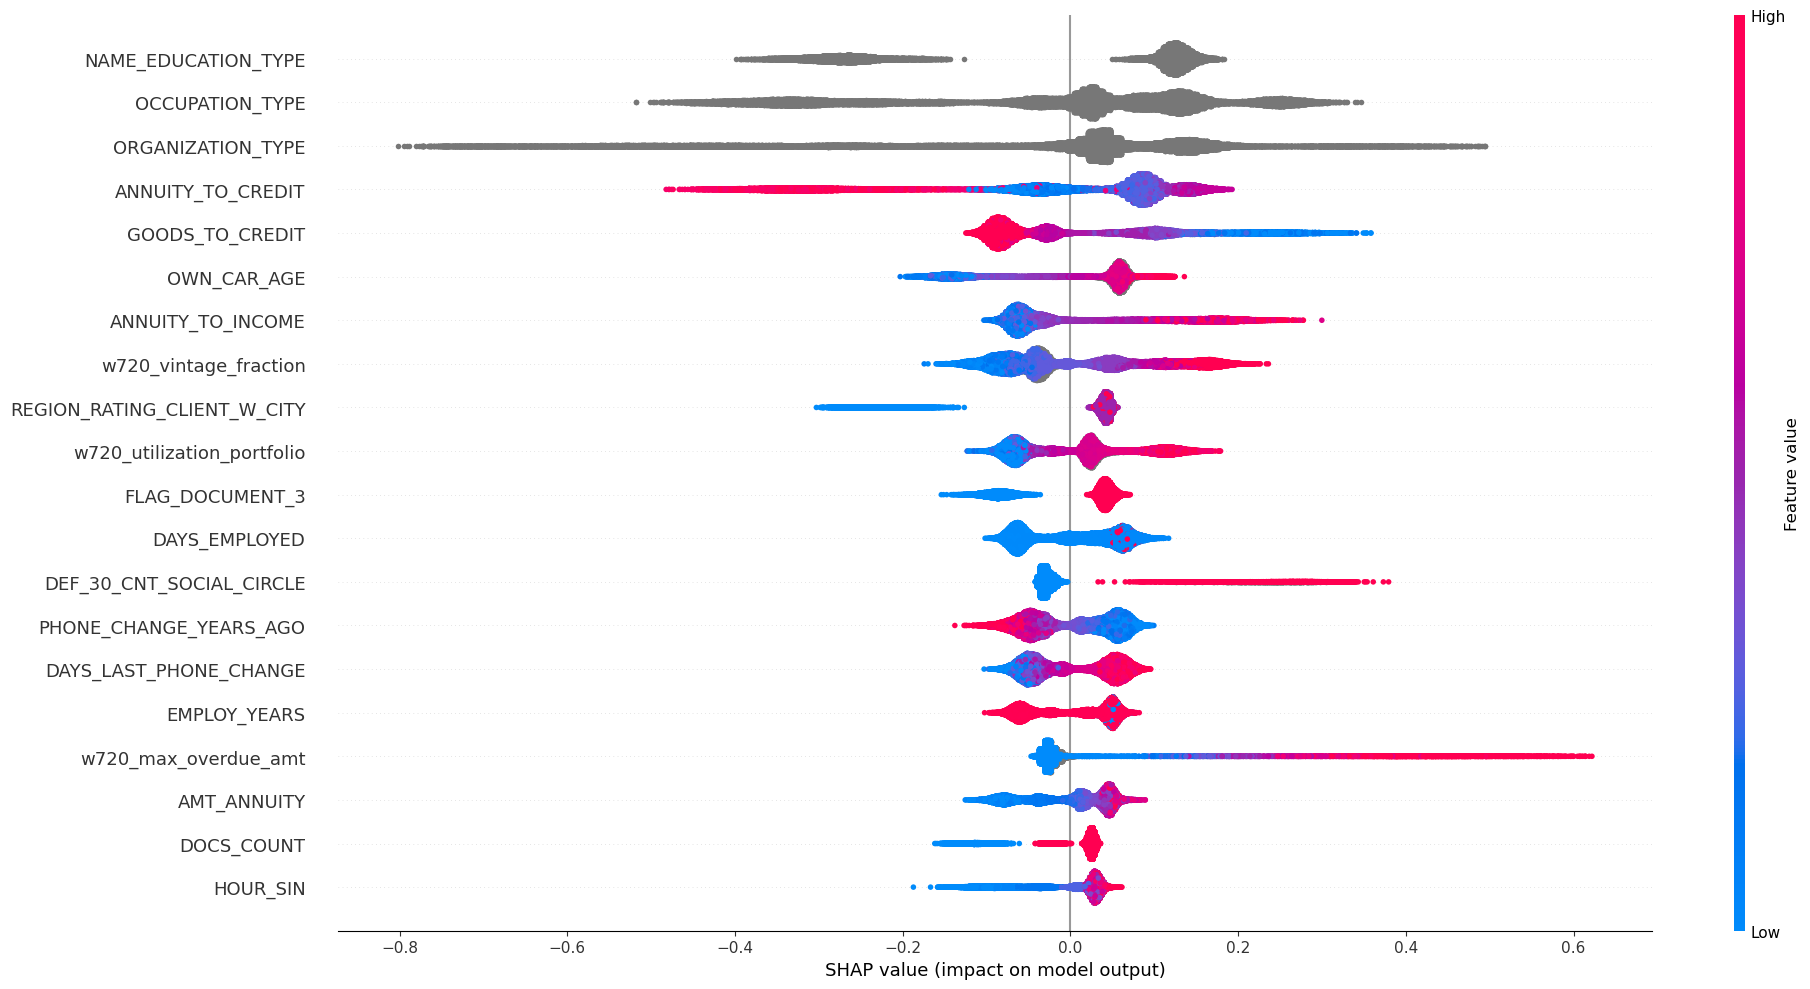

In [71]:
base_model_lgbm.plot_shap_summary_plot(X_sim_train,max_display=20, plot_size=(20,10))

In [738]:
y_sim_val_pred_lgbm = base_model_lgbm.predict_proba(X_sim_val)[:,1]
y_sim_val_pred_cb = base_model.predict_proba(X_sim_val)[:,1]
y_sim_val_pred_oracle = oracle_model.predict_proba(X_sim_val)[:,1]


In [703]:
from scipy.special import expit, logit

In [740]:
cutoff_confusion_matrix(y_sim_val, y_sim_val_pred_oracle, cutoff_fraction=0.7, profit_margin=3, loss_cost = 10)

{'cutoff_threshold': 0.10114187779831826,
 'TN (bad_rejected)': 3392,
 'FP (good_rejected)': 7498,
 'FN (bad_accepted)': 38,
 'TP (good_accepted)': 508,
 'approval_rate': 0.047743966421825816,
 'bad_rate_in_accepted': 0.0695970695970696,
 'rejection_efficiency': 0.3114784205693297,
 'expected_profit': 1144}

In [726]:
len(y_sim_val_pred_lgbm<0.05196198666323377)

11436

In [725]:
7779+3111

10890

In [736]:
f_recall(y_sim_val, y_sim_val_pred_lgbm,threshold=0.025225406788410034)

0.9029304029304029

In [737]:
f_precision(y_sim_val, y_sim_val_pred_lgbm,threshold=0.025225406788410034)

0.061578815888083935